In [1]:
from medpy.io import load
import numpy as np
from torch.utils.data.dataset import Dataset
import torch
import os

In [2]:
rootdir = 'Data/ABCs_training_data'
datanames = {'ct':sorted([file for file in os.listdir(rootdir) if file.endswith('ct.mha')]), 
             't1':sorted([file for file in os.listdir(rootdir) if file.endswith('t1.mha')]), 
             't2':sorted([file for file in os.listdir(rootdir) if file.endswith('t2.mha')])}
len(datanames['ct'])

45

In [3]:
label_list = sorted([file for file in os.listdir(rootdir) if file.endswith('task1.mha')])
len(label_list)

45

In [7]:
# Custom Dataset
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# https://github.com/jcreinhold/niftidataset/blob/master/niftidataset/dataset.py#L41
from medpy.io import load
import numpy as np
from torch.utils.data.dataset import Dataset
import torch
import os


class ABCsDataset(Dataset):
    """ABCs dataset."""

    def __init__(self, root_dir, task=1, stacked=False, axis:int=0, preload=False, transform=None, segmentation=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform
        self.stacked = stacked
        self.axis = axis
        self.preload = preload
        self.segmentation = segmentation
        # old sample = {'ct':Tensor, 't1':Tensor, 't2':Tensor, 'Mask': label}
        # sample = ((Tensor1, Tensor2, Tensor3), Mask)
        # sample = (stacked_tensor, mask)
        
        modenames = ['ct', 't1', 't2']
        self.datanames = {}
        for modename in modenames:
            self.datanames[modename] = sorted([file for file in os.listdir(root_dir) if file.endswith(f'{modename}.mha')])
        
        if task==1:
            self.labelnames = sorted([file for file in os.listdir(root_dir) if file.endswith('task1.mha')])
        
        elif task==2:
            self.labelnames = sorted([file for file in os.listdir(root_dir) if file.endswith('task2.mha')])
            
        assert len(self.datanames) != len(self.labelnames), 'Label-Data mismatch'
        
        if self.preload:
            self.dataset = []
            if not self.stacked:
                for i, label in enumerate(self.labelnames):
                    sample = ([self.get_data(self.datanames[key][i]) for key in self.datanames.keys()],
                              self.get_data(label))
                    self.dataset.append(sample)

            else:
                for i, label in enumerate(self.labelnames):
                    sample = (self.stack([self.get_data(self.datanames[key][i]) for key in self.datanames.keys()]),
                              self.get_data(label))
                    self.dataset.append(sample)
     
    # https://stackoverflow.com/questions/48608585/where-is-the-len-function-used-in-pytorch-dataset
    def __len__(self):
         
        return len(self.datanames[list(self.datanames.keys())[0]])

    
    def __getitem__(self, idx):
        
        # https://stackoverflow.com/questions/53916594/typeerror-object-of-type-numpy-int64-has-no-len
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if not self.preload:
           
            if not self.stacked:
                sample = ([self.get_data(self.datanames[key][idx]) for key in self.datanames.keys()],
                              self.get_data(self.labelnames[idx]))
            else:
                sample = (self.stack([self.get_data(self.datanames[key][idx]) for key in self.datanames.keys()]),
                              self.get_data(self.labelnames[idx]))
                
        else:
            sample = self.dataset[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        if self.segmentation:
            sample = (sample[0], sample[1].squeeze())  # for segmentation, loss expects no channel dim
        
        return sample

    def get_data(self, path):
        path = os.path.join(self.root_dir, path)
        image_data, image_header = load(path)
        return image_data

    
    def stack(self, im_list):
        return np.swapaxes(np.concatenate(im_list, axis=self.axis), 0, self.axis)
    


In [8]:
rootdir = 'Data/ABCs_training_data'
dataset = ABCsDataset(root_dir=rootdir, stacked=True, preload=False, axis=0)

In [9]:
print(len(dataset[24]))
print(dataset[0][1].shape)

2
(164, 194, 142)


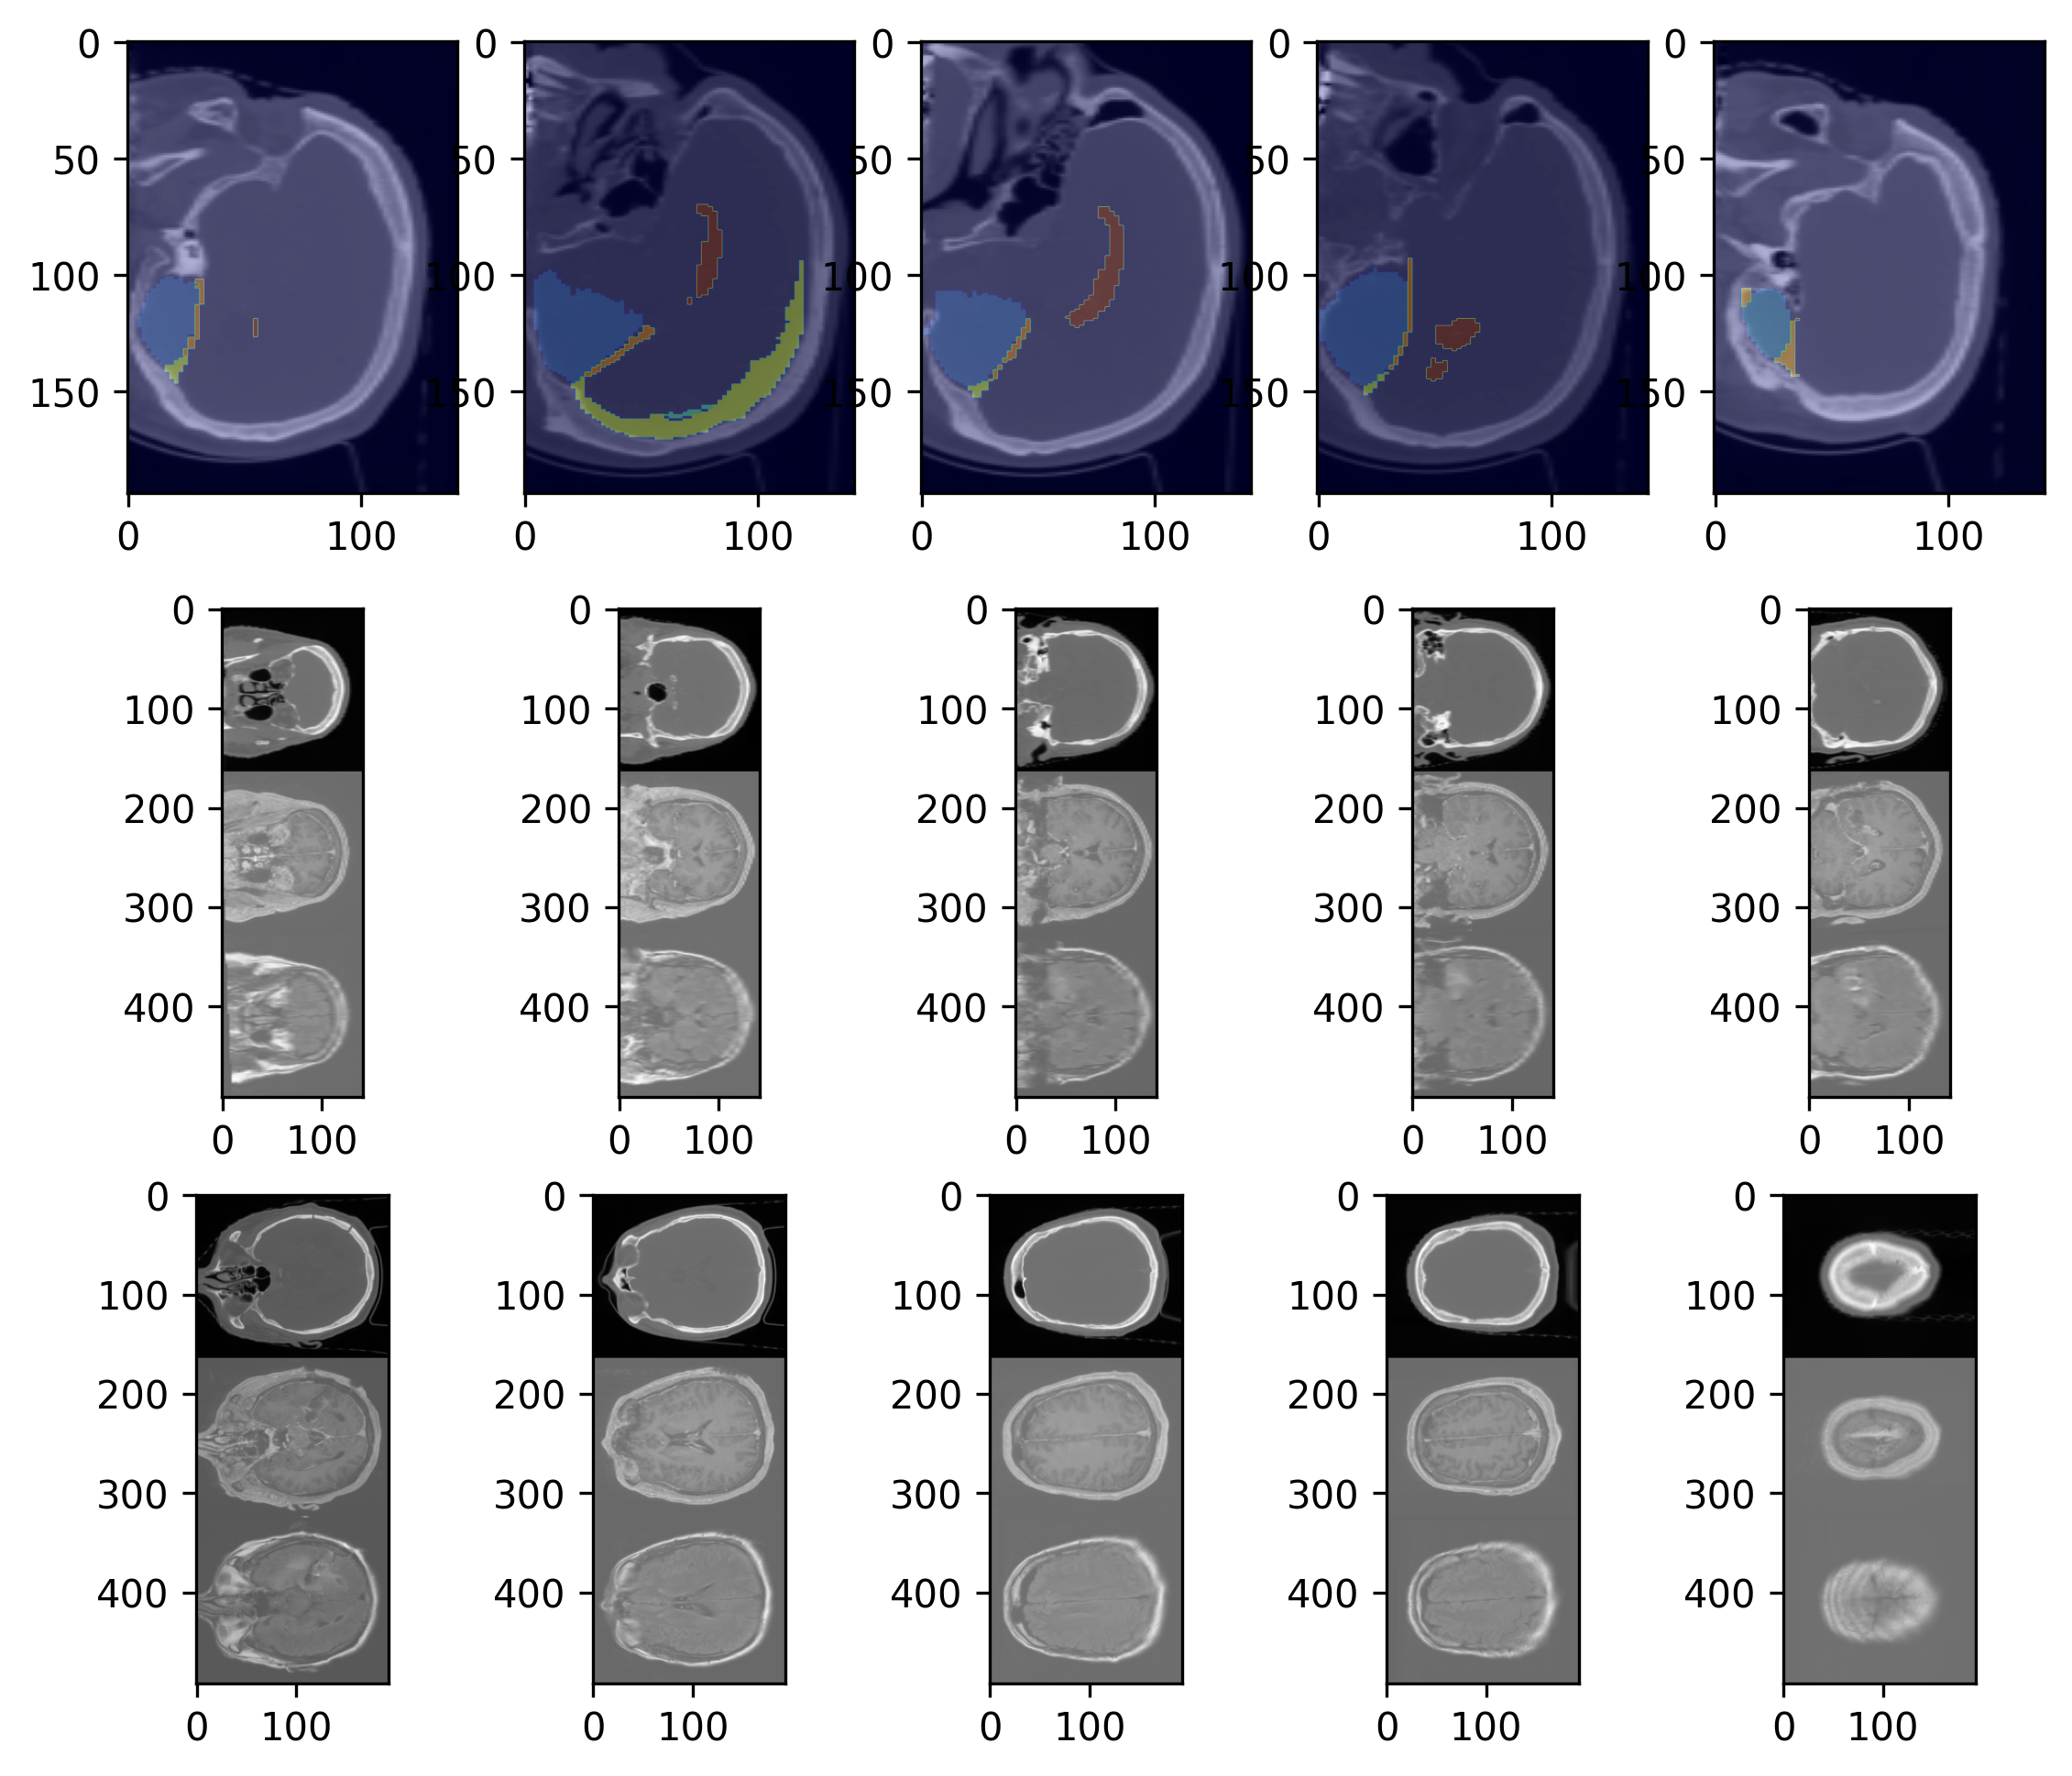

In [13]:
import matplotlib.pyplot as plt


rootdir = 'Data/ABCs_training_data'
dataset = ABCsDataset(root_dir=rootdir, stacked=True, preload=False, task=1,axis=0)
# sample = (stacked_tensor, mask)
image_data = dataset[0][0]
label_data = dataset[0][1]

index_list = [50, 75, 90, 100, 120]
fig, ax = plt.subplots(nrows=3, ncols=len(index_list), figsize=(9, 8), dpi= 300, facecolor='w', edgecolor='k')

for k, l in enumerate(index_list):
    # Show an image in each subplot
    ax[0][k].imshow(image_data[l,:,:], cmap='gist_gray')
    ax[0][k].imshow(label_data[l,:,:], cmap='jet', alpha=0.3)
    
    ax[1][k].imshow(image_data[:,l,:], cmap='gist_gray')
    #ax[1][k].imshow(label_data[:,l,:], cmap='jet', alpha=0.3)

    ax[2][k].imshow(image_data[:,:,l], cmap='gist_gray')
    #ax[2][k].imshow(label_data[:,:,l], cmap='jet', alpha=0.3)

In [79]:
dataset = ABCsDataset(root_dir='Data/ABCs_training_data', stacked=True, preload=True, task=1, axis=0)

# WIP
# add test parameter to dataset class
# testset = ABCsDataset(root_dir='Data/ABCs_test1', stacked=True, preload=False, task=1, axis=0)

In [80]:
print('Dataset: ', len(dataset))

print(np.shape(dataset))

Dataset:  45
(45, 2)
